In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import operator

In [2]:
spark = SparkSession.builder.appName("Chicago crime")\
.config("spark.some.config.option", "some-value")\
.config("spark.driver.memory", "4g")\
.getOrCreate()

In [3]:
data=spark.read.option("header", "true")\
        .option("inferSchema", "true")\
        .csv("/home/hai-feng/Documents/dohaWeather/*.csv")

In [4]:
df = data.toPandas()

In [5]:
df.head()

,Converted time,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,...,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction,_c46
0,2011-12-31 21:00:00,OTBD,observation,1.325372e+09,OTBD,Doha Intl,1.325365e+09,N,64,33.0,...,null,null,null,null,null,null,null,null,null,None
1,2011-12-31 21:30:00,OTBD,observation,1.325374e+09,OTBD,Doha Intl,1.325367e+09,N,64,33.0,...,null,null,null,null,null,null,null,null,null,None
2,2011-12-31 22:00:00,OTBD,observation,1.325376e+09,OTBD,Doha Intl,1.325369e+09,N,64,33.0,...,null,null,null,null,null,null,null,null,null,None
3,2011-12-31 22:30:00,OTBD,observation,1.325378e+09,OTBD,Doha Intl,1.325371e+09,N,64,33.0,...,null,null,null,null,null,null,null,null,null,None
4,2011-12-31 23:00:00,OTBD,observation,1.325380e+09,OTBD,Doha Intl,1.325372e+09,N,64,33.0,...,null,null,null,null,null,null,null,null,null,None


In [6]:
df = df[["Converted time", "temp"]]

In [7]:
df.shape

(248136, 2)

In [8]:
df = df.dropna(how='any')
df = df[~df.isin(["null"]).any(axis=1)]
df.shape

(247325, 2)

In [9]:
# df["Converted time"] = df["Converted time"].astype("")
df["Converted time"] = pd.to_datetime(df["Converted time"])
df["temp"] = pd.to_numeric(df["temp"])

In [10]:
df.dtypes

Converted time    datetime64[ns]
temp                       int64
dtype: object

In [11]:
df.head(57)

,Converted time,temp
0,2011-12-31 21:00:00,64
1,2011-12-31 21:30:00,64
2,2011-12-31 22:00:00,64
3,2011-12-31 22:30:00,64
4,2011-12-31 23:00:00,64
5,2011-12-31 23:30:00,64
6,2012-01-01 00:00:00,64
7,2012-01-01 00:30:00,63
8,2012-01-01 01:00:00,63
9,2012-01-01 02:00:00,63


In [12]:
df.isin(["null","NaN","Null"]).sum().sort_values(ascending = False).head(19)

temp              0
Converted time    0
dtype: int64

In [263]:
X_train, X_test, y_train, y_test = train_test_split\
        (df[["Converted time"]],\
         df[["temp"]],test_size=0.30 )

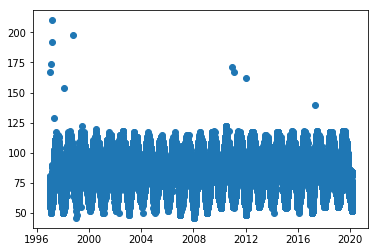

In [264]:
plt.scatter(x=df["Converted time"].values, y=df["temp"])

In [266]:
x = df[["Converted time"]].values
y = df[["temp"]]

13.583100635217841
0.0010533813871778097


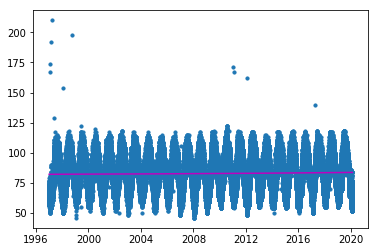

In [267]:

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

1.686539078260566
0.8498918649170673


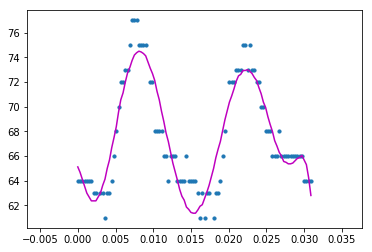

In [286]:
df_small = df[:100]
df_small = df_small.sort_values("Converted time")
df_small["Converted time"] = df_small["Converted time"].astype(np.int64).subtract(1325365200000000000).divide(6000000000000000)
df_small["quadratic"] = df_small["Converted time"]**2
df_small["biquadrate"] = df_small["Converted time"]**4
# df_small = df_small.dropna(how='any')

x = df_small[["Converted time", "quadratic", "biquadrate"]]
y = df_small[["temp"]]
polynomial_features= PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

plt.scatter(x["Converted time"], y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x["Converted time"],y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='m')
plt.show()

In [274]:
# df_small["Converted time"].dt.hour
# df['full_minute'] = (df['Converted time'].dt.year - 2011) * 525600 + (df['Converted time'].dt.month - 12) * 525600 + df['Converted time'].dt.hour - 21 * 60 + df['time'].dt.second
# df_small["Converted time"].astype(np.int64).head(10).divide(100000000000).subtract(13253652)
# df_small["Converted time"].div(10000)
# df_small.head(10)
# x
# df_small["Converted time"] = df_small["Converted time"].astype(np.int64).head(10).divide(100000000000).subtract(13253652)

# df_small.isna().sum().sort_values(ascending = False).head(19)
# .subtract(1325365200000000).divide(600000000000)1325365200000000000
# df_small = df[:100]
# df_small["Converted time"] = df_small["Converted time"].astype(np.int64).subtract(1325365200000000000).divide(6000000000000)
# df_small["quadratic"] = np.square(df_small["Converted time"])

df_small

,Converted time,temp,quadratic
0,0.0,64,0.0
1,3.0,64,9.0
2,6.0,64,36.0
3,9.0,64,81.0
4,12.0,64,144.0
5,15.0,64,225.0
6,18.0,64,324.0
7,21.0,63,441.0
8,24.0,63,576.0
9,30.0,63,900.0


In [328]:
df = df.sort_values(by="Converted time", ascending=False)
# df_train, df_test, df_left= np.split(df, [int(0.1*len(df)), int(0.12*len(df))])
df_train = df[:1000]
df_test = df[1000:1200]

In [303]:
# df_train.shape
# df_test.shape
# df_left.shape

(0, 2)

/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


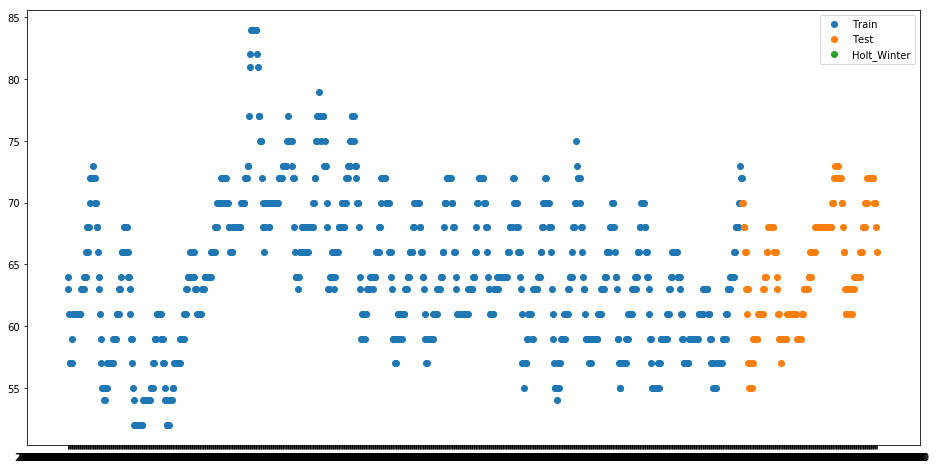

In [339]:
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm

y_hat_avg = df_test.copy()
# fit1 = ExponentialSmoothing(np.asarray(df_train['temp']), seasonal_periods=4, trend='additive', seasonal='additive').fit()
fit1 = sm.tsa.statespace.SARIMAX(df_train.temp, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
# y_hat_avg['Holt_Winter'] = fit1.forecast(len(df_test))
y_hat_avg['Holt_Winter'] = fit1.predict(dynamic=True)

plt.figure(figsize=(16, 8))
plt.scatter(df_train['Converted time'].astype('str'),df_train['temp'], label='Train')
plt.scatter(df_test['Converted time'].astype('str'),df_test['temp'], label='Test')
plt.scatter(y_hat_avg['Converted time'].astype('str'), y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [342]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
 
# rms = sqrt(mean_squared_error(df_test['temp'], y_hat_avg['Holt_Winter']))
# print(rms)
# y_hat_avg.isna().sum()
y_hat_avg

,Converted time,temp,Holt_Winter
247135,2020-01-25 08:30:00,70,NaN
247134,2020-01-25 08:00:00,70,NaN
247133,2020-01-25 07:30:00,68,NaN
247132,2020-01-25 07:00:00,68,NaN
247131,2020-01-25 06:30:00,66,NaN
247130,2020-01-25 06:00:00,66,NaN
247129,2020-01-25 05:30:00,63,NaN
247128,2020-01-25 05:00:00,61,NaN
247127,2020-01-25 04:30:00,63,NaN
247126,2020-01-25 04:00:00,57,NaN


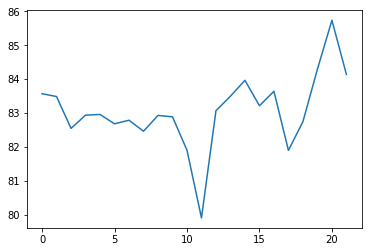

In [25]:
averages = []
for i in range(1998,2020):
    average = df[df["Converted time"].dt.year == i].temp.mean()
    averages.append(average)
averages
plt.plot(averages)


In [100]:
dfwithouthalfhour = df[df["Converted time"].dt.minute == 0].drop_duplicates(subset='Converted time')
dfwithouthalfhour.index = dfwithouthalfhour["Converted time"]
dfwithouthalfhour=dfwithouthalfhour.resample("H").backfill().reset_index(drop = True)
dfwithouthalfhour
# # dfwithouthalfhour.index

,Converted time,temp
0,1996-12-31 21:00:00,66
1,1996-12-31 22:00:00,64
2,1996-12-31 23:00:00,64
3,1997-01-01 00:00:00,64
4,1997-01-01 01:00:00,64
5,1997-01-01 02:00:00,63
6,1997-01-01 03:00:00,63
7,1997-01-01 04:00:00,63
8,1997-01-01 05:00:00,64
9,1997-01-01 06:00:00,68


In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm

df = dfwithouthalfhour.sort_values(by="Converted time", ascending=False)
# df_train, df_test, df_left= np.split(df, [int(0.1*len(df)), int(0.12*len(df))])
df_train = dfwithouthalfhour[:192689]
df_test = dfwithouthalfhour[192689:]

y_hat_avg = df_test.copy()
fit1 = ExponentialSmoothing(np.asarray(df_train['temp']), seasonal_periods=24, trend='additive', seasonal='additive').fit()
y_hat_avg['Prediction'] = fit1.forecast(len(df_test))

# fit1 = sm.tsa.statespace.SARIMAX(df_train.temp, order=(2, 1, 4), seasonal_order=(0, 1, 1, 7)).fit()
# y_hat_avg['Holt_Winter'] = fit1.predict(dynamic=True)

plt.figure(figsize=(16, 8))
plt.scatter(df_train['Converted time'].astype('str'),df_train['temp'], label='Train')
plt.scatter(df_test['Converted time'].astype('str'),df_test['temp'], label='Test')
plt.scatter(y_hat_avg['Converted time'].astype('str'), y_hat_avg['Prediction'], label='Prediction')
plt.legend(loc='best')
plt.show()

/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:203: RuntimeWarning: overflow encountered in double_scalars
  (alphac * (l[i - 1] + phi * b[i - 1]))
/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:206: RuntimeWarning: overflow encountered in double_scalars
  (gamma * (l[i - 1] + phi * b[i - 1])) + (gammac * s[i - 1])
/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:204: RuntimeWarning: invalid value encountered in double_scalars
  b[i] = (beta * (l[i] - l[i - 1])) + (betac * phi * b[i - 1])
/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:207: RuntimeWarning: overflow encountered in add
  return sqeuclidean((l + phi * b) + s[:-(m - 1)], y)
/home/hai-feng/anaconda3/envs/bigdata-lab/lib/python3.5/site-packages/statsmodels/tsa/holtwinters.py:689: RuntimeWarning: overflow encountered

In [106]:
from sklearn.metrics import mean_squared_error
from math import sqrt
 
rms = sqrt(mean_squared_error(df_test['temp'], y_hat_avg['Holt_Winter']))
print(rms)

2.6090285540278524
